In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
train_data = pd.read_csv("twitter_training.csv")
test_data = pd.read_csv("twitter_validation.csv")

print(train_data.shape)
print(test_data.shape)

(74682, 4)
(1000, 4)


In [4]:
train_data.isnull().sum()

Tweet ID           0
entity             0
sentiment          0
Tweet content    686
dtype: int64

In [5]:
test_data.isnull().sum()

Tweet ID         0
entity           0
sentiment        0
Tweet content    0
dtype: int64

In [6]:
train_data.head()

,Tweet ID,entity,sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
test_data.head()

,Tweet ID,entity,sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [8]:
test_data.describe()

,Tweet ID
count,1000.000000
mean,6432.088000
std,3728.310569
min,6.000000
25%,3247.750000
50%,6550.000000
75%,9661.750000
max,13197.000000


In [16]:
custom_stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about",
    "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up",
    "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when",
    "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no",
    "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should",
    "now"
])
#we should add im also, because peole use that more


In [18]:
def preprocess_text(text):
    words = str(text).lower().split()
    words = [word for word in words if word.isalpha() and word not in custom_stop_words]
    return " ".join(words)

train_data['processed_text'] = train_data["Tweet content"].apply(preprocess_text)
test_data['processed_text'] = test_data['Tweet content'].apply(preprocess_text)

In [19]:
train_data.head(10)

,Tweet ID,entity,sentiment,Tweet content,processed_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming borders kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something know huge fan may...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,spent couple hours something know huge borderl...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,spent hours something know huge borderlands fa...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something know huge rhandle...


In [21]:
sample_tweets = train_data['processed_text'].unique()[:5]
for i, tweet in enumerate(sample_tweets):
    print(f"Tweet {i+1}: {tweet}")

Tweet 1: im getting borderlands murder
Tweet 2: coming borders kill
Tweet 3: im getting borderlands kill
Tweet 4: im coming borderlands murder
Tweet 5: spent hours making something know huge fan maya one favorite decided make wallpaper original image versus creation made


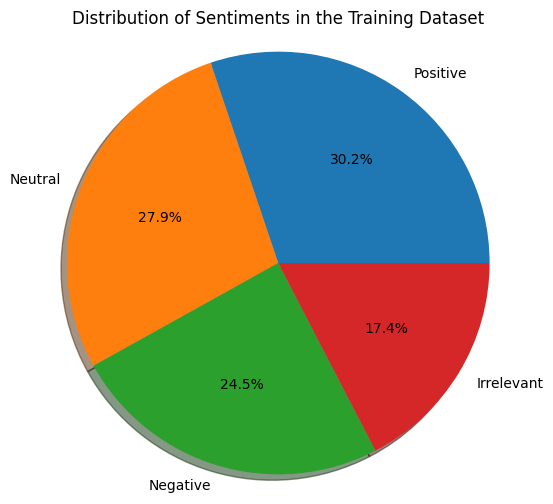

In [24]:
import matplotlib.pyplot as plt

unique_sentiments = train_data["sentiment"].unique()
train_sentiment_counts = train_data["sentiment"].value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.pie(train_sentiment_counts, labels=unique_sentiments, autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Sentiments in the Training Dataset')
plt.axis('equal')
plt.show()

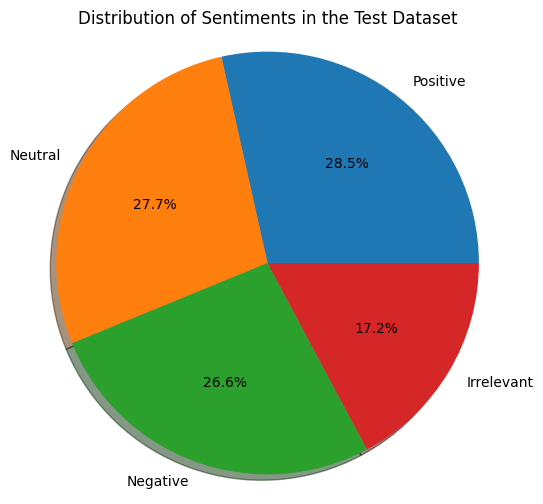

In [25]:
# Visualize the distribution of sentiments in the test dataset
test_sentiment_counts = test_data["sentiment"].value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.pie(test_sentiment_counts, labels=unique_sentiments, autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Sentiments in the Test Dataset')
plt.axis('equal')
plt.show()

In [42]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data["processed_text"])
X_test = vectorizer.transform(test_data["processed_text"])
y_train = train_data["sentiment"]
y_test = test_data["sentiment"]

In [33]:
X_train.__str__

<bound method _spbase.__str__ of <74682x22622 sparse matrix of type '<class 'numpy.float64'>'
	with 572676 stored elements in Compressed Sparse Row format>>

In [43]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [44]:
y_pred = classifier.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.769
Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.94      0.54      0.69       172
    Negative       0.67      0.91      0.77       266
     Neutral       0.91      0.68      0.78       285
    Positive       0.73      0.87      0.79       277

    accuracy                           0.77      1000
   macro avg       0.81      0.75      0.76      1000
weighted avg       0.80      0.77      0.77      1000

Confusion Matrix:
[[ 93  37   9  33]
 [  1 242   5  18]
 [  2  52 193  38]
 [  3  28   5 241]]


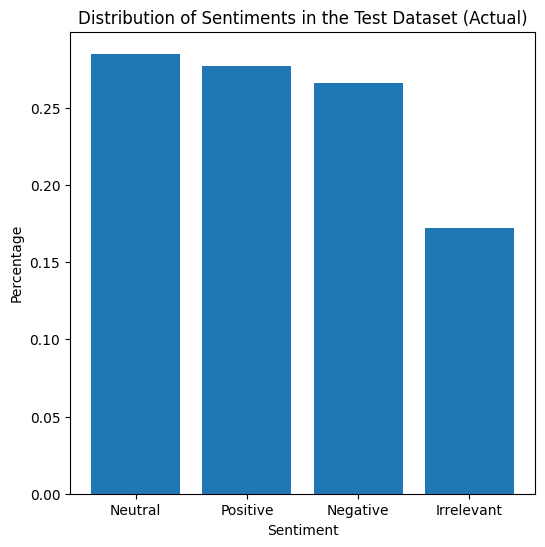

Accuracy: 0.769


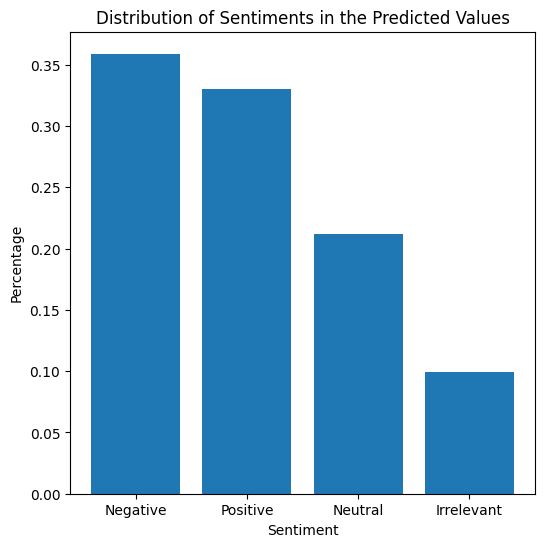

In [47]:
# Visualize the distribution of sentiments in the test dataset (actual values)
actual_sentiment_counts = test_data["sentiment"].value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.bar(actual_sentiment_counts.index, actual_sentiment_counts.values)
plt.title('Distribution of Sentiments in the Test Dataset (Actual)')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.show()

# Model evaluation on the test set and predict values
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Visualize the distribution of sentiments in the predicted values
predicted_sentiment_counts = pd.Series(y_pred).value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.bar(predicted_sentiment_counts.index, predicted_sentiment_counts.values)
plt.title('Distribution of Sentiments in the Predicted Values')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.show()


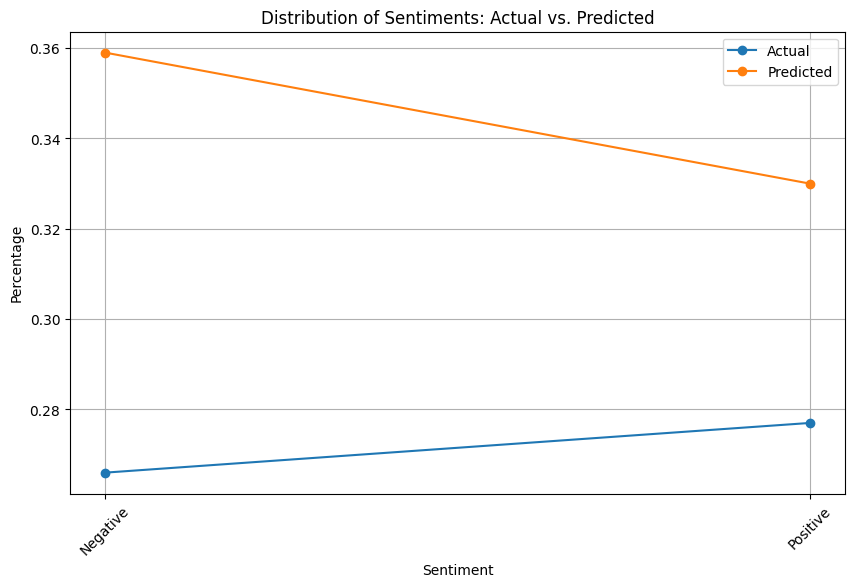

In [48]:
# Calculate the distribution of sentiments in the test dataset (actual values)
actual_sentiment_counts = test_data["sentiment"].value_counts(normalize=True)

# Calculate the distribution of sentiments in the predicted values
y_pred = classifier.predict(X_test)
predicted_sentiments = pd.Series(y_pred)
predicted_sentiment_counts = predicted_sentiments.value_counts(normalize=True)

# Concatenate the actual and predicted sentiment counts into a single DataFrame
sentiment_counts_df = pd.DataFrame({'Actual': actual_sentiment_counts, 'Predicted': predicted_sentiment_counts})
sentiment_counts_df = sentiment_counts_df.fillna(0)  # Fill NaN with 0 if some sentiments are missing in prediction

# Sort the DataFrame by sentiment labels for consistent ordering in the line chart
sentiment_counts_df = sentiment_counts_df.reindex(sentiment_labels)

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(sentiment_counts_df.index, sentiment_counts_df['Actual'], marker='o', label='Actual')
plt.plot(sentiment_counts_df.index, sentiment_counts_df['Predicted'], marker='o', label='Predicted')
plt.title('Distribution of Sentiments: Actual vs. Predicted')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


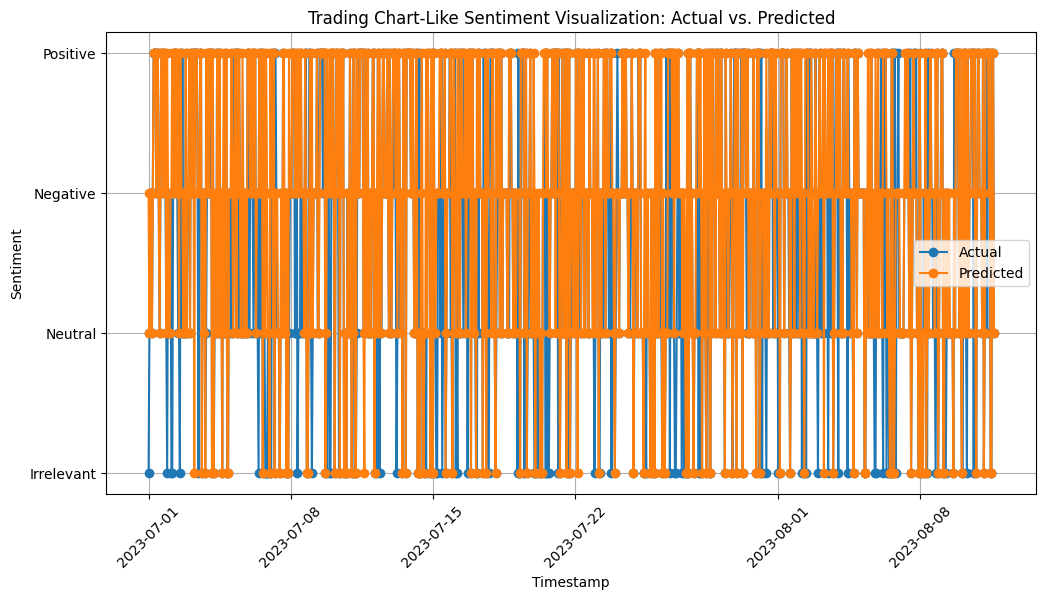

In [49]:
# Generate a hypothetical timestamp for the test data
test_data["timestamp"] = pd.date_range(start="2023-07-01", periods=len(test_data), freq="H")

# Calculate the distribution of sentiments in the test dataset (actual values)
actual_sentiment_counts = test_data["sentiment"].value_counts(normalize=True)

# Calculate the distribution of sentiments in the predicted values
y_pred = classifier.predict(X_test)
predicted_sentiments = pd.Series(y_pred)
predicted_sentiment_counts = predicted_sentiments.value_counts(normalize=True)

# Concatenate the actual and predicted sentiment counts into a single DataFrame
sentiment_counts_df = pd.DataFrame({'Actual': actual_sentiment_counts, 'Predicted': predicted_sentiment_counts})
sentiment_counts_df = sentiment_counts_df.fillna(0)  # Fill NaN with 0 if some sentiments are missing in prediction

# Sort the DataFrame by sentiment labels for consistent ordering in the line chart
sentiment_counts_df = sentiment_counts_df.reindex(sentiment_labels)

# Plot the trading chart-like visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data["timestamp"], test_data["sentiment"], label='Actual', marker='o')
plt.plot(test_data["timestamp"], y_pred, label='Predicted', marker='o')
plt.title('Trading Chart-Like Sentiment Visualization: Actual vs. Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Sentiment')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
